In [1]:
import sys
sys.path.append("../")  # go to parent directory

from collections import Counter
from nltk import word_tokenize
import mapply
import pandas as pd

from src.utils import read_csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the data 
path_to_train_data = "../data/training.csv"
col_names = ['id','entity','labels','text']
df = read_csv(path_to_train_data, col_names)
df.head(5)

,id,entity,labels,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### Cleaning the dataset

In [3]:
df_shape = df.shape
print(f"Dataset has {df_shape[0]} observations with {df_shape[1]} features:\n{', '.join(df.columns)}.")

Dataset has 74682 observations with 4 features:
id, entity, labels, text.


In [4]:
# Check duplicated rows and remove duplicates
duplicate_count = df.duplicated().sum()
print(f"There are {duplicate_count} duplicates in the dataset.\n")

# Check for missing values
missing_values = df.isnull().sum()
print(f"There are following missing values in the dataset:\n{missing_values}.")


There are 2700 duplicates in the dataset.

There are following missing values in the dataset:
id          0
entity      0
labels      0
text      686
dtype: int64.


In [5]:
# Remove duplicates
df.drop_duplicates(keep="last", inplace=True)
df.shape

(71982, 4)

In [6]:
# Remove rows with missing 'text' values
df = df.dropna(subset=['text'])
df

,id,entity,labels,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


### Exploratory data analysis (EDA)

In [7]:
# Basic statistics of the dataset
data_stats = {
    "Total entries": len(df),
    "Unique entities": df['entity'].nunique(),
    "Unique labelss": df['labels'].nunique()
}
data_stats

{'Total entries': 71656, 'Unique entities': 32, 'Unique labelss': 4}

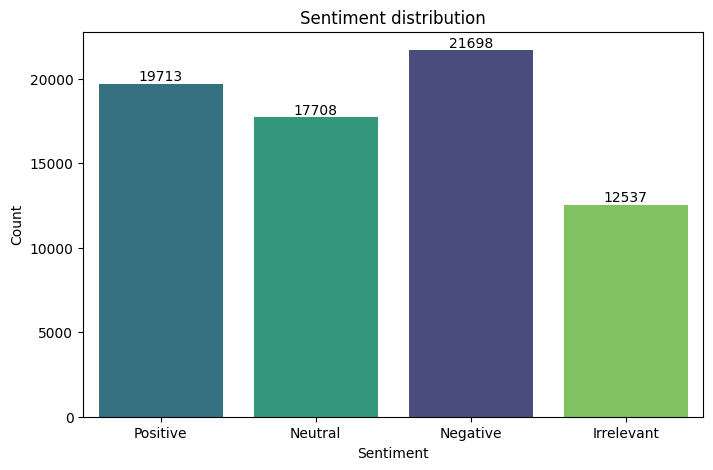

In [8]:
# Distribution of labels classes
labels_distribution = df['labels'].value_counts()

# Plotting labels distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='labels',  hue_order=df['labels'].value_counts().index, palette='viridis', hue='labels')
for container in ax.containers:
        ax.bar_label(container)
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [9]:
# df[df['labels'] == 'Irrelevant']

**Observations**:
* **Class imbalance**:
    * The dataset shows a clear imbalance between the different labels classes. Negative Sentiments dominate, followed by Positive and Neutral Sentiments, with Irrelevant Sentiments being the least common.
    * This class imbalance should be addressed during model training to ensure the model does not become biased towards the more frequent classes.
* **Sentiment Trends**:
    * The high number of Negative Sentiments indicates a potential focus on complaints, issues, or criticisms within the dataset.
    * The significant number of Positive Sentiments suggests that there is also a significant number of positive feedback.
    * Neutral Sentiments provide a balanced viewpoint, reflecting tweets that do not express strong opinions.
    * The relatively lower number of Irrelevant Sentiments indicates that most tweets are suitable for analysis, which is good for the quality of the Sentiment analysis.

#### Entity labels distribution

In [10]:
# Entity Analysis (Entity labels Distribution)
# Group by entity and labels to get the count of each labels per entity
entity_labels_distribution = df.groupby(['entity', 'labels']).size().unstack().fillna(0)
entity_labels_distribution

labels,Irrelevant,Negative,Neutral,Positive
entity,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,972
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [12]:
# Plotting entity labels distribution for top entities
top_entities = df['entity'].value_counts().index[:10]
entity_labels_distribution_top = entity_labels_distribution.loc[top_entities]
entity_labels_distribution_top

labels,Irrelevant,Negative,Neutral,Positive
entity,,,,
TomClancysRainbowSix,92,1110,628,498
Verizon,177,1070,552,520
MaddenNFL,86,1665,191,373
CallOfDuty,660,861,367,426
Microsoft,167,748,816,573
WorldOfCraft,210,328,1047,715
NBA2K,175,1450,265,409
LeagueOfLegends,298,616,800,582
TomClancysGhostRecon,23,887,776,605


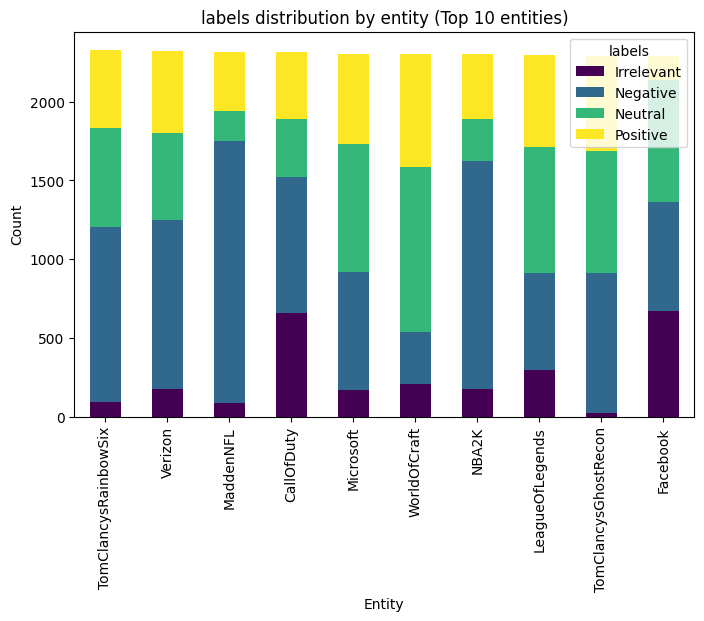

In [13]:
# Plotting the distribution
entity_labels_distribution_top.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='viridis')
plt.title('labels distribution by entity (Top 10 entities)')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.legend(title='labels', loc='best')
plt.show()

#### Analysis of word count distribution

In [14]:
# Count words number in "text" for each entry
mapply.init(n_workers=mapply.parallel.sensible_cpu_count(), chunk_size=2, max_chunks_per_worker=2, progressbar=True)

df['word_count'] = df['text'].mapply(lambda sent: len(word_tokenize(sent)))
df

  0%|                                                                                                         …

,id,entity,labels,text,word_count
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,11
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,13
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,11
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,11
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,13
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,26
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,24
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,27
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,32


In [15]:
df['word_count'].describe()

count    71656.000000
mean        22.972535
std         17.163287
min          0.000000
25%         10.000000
50%         19.000000
75%         32.000000
max        198.000000
Name: word_count, dtype: float64

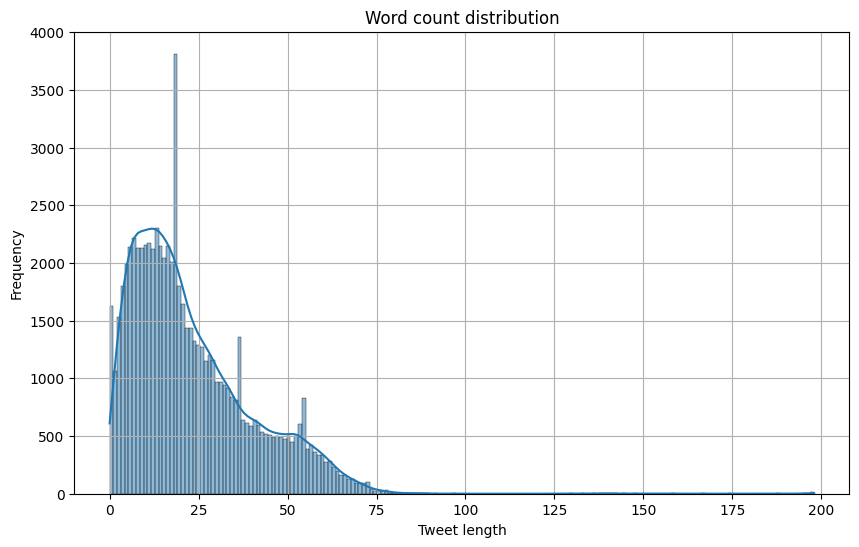

In [16]:
# Word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=df['word_count'], kde=True)
plt.title('Word count distribution')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

**Observations**:

* The highest frequency of tweets is clustered around the _lower word counts_, particularly between 0 and 20 words. This indicates that most tweets in the dataset are relatively short.
* As the number of words in tweets increases beyond 20, the frequency gradually decreases. This suggests that fewer tweets have longer text.
* There are occasional spikes in certain word counts, which may indicate certain patterns or repeated phrases in the data set. These outliers may require further investigation to understand their nature.
* The distribution has a long tail extending up to about 200 words, indicating that there are some tweets with exceptionally high word counts. This could be due to concatenated tweets, spam, or noise in the data.

In [17]:
# Show tweets with the most words
pd.set_option('display.max_colwidth', None)
df[df['word_count'] >= 100].sort_values(by=['word_count'])

,id,entity,labels,text,word_count
57362,11439,TomClancysRainbowSix,Neutral,.... mixer.com / makavelincheese or makavelincheese.. @ ShoutGamers... @ share _ stream... @ tchSharing.. @ tchGaming.. @ tchOnline... @ tchBot... @ tchGaming... @ tchGaming... @ tchGaming... @ tchGaming.. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @ tchGaming. @,100
73102,8923,Nvidia,Positive,K My long short term stock holdings are really working out well for me [UNK].. I also do dabble in stock options often.. 1. Tesla ( Wow ). 2. Power Appian ( wow ). 3. Sleep Fastly ( but Wow ). 4. Sea Limited ( wow ). 8 5. Nvidia ( wow ). 6. Farfetch ( ok ). 7 7. Redfin ( ok ). 8. Work ( recovering ). 9. Chewy ( or ok ). 10. Well health tech,102
64265,7810,MaddenNFL,Negative,"@EAMaddenNFL I have a player... but I sense a Beef in y’all, y’all need to talk it whoever does your rating’s, cuz each year you screw us... last year people just screwed T <unk>. <unk>. <unk>. & @Keenan13Allen <unk>. <unk>. <unk>. <unk>. <unk>. this year they screwed H <unk>. <unk>. <unk>. <unk>. <unk>. DO BETTER!!!",109
6322,287,Amazon,Neutral,by Dart Against Humanity 2 Ep. 79 ( 9 S5 E4 ) : The New New Not to Normal.. Apple : itunes. apple. com / us / podcast / 254 dar ….. Google : google. com / podcasts? feed = ….. o Google Play : play. google. com / music / listen.. Spotify : open. o spotify. com / show / 7oyFdHIm6 ….. A iHeartRadio : iheart. com / podcast / 256 - da ….. Pandora :... pandora. com / podcast / dart - a ….. * Amazon Alexa https://t.co/uCZfIRX9Ip ],112
32594,7591,LeagueOfLegends,Positive,playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing is SO enjoyable playing in 0.3% league tile Clothing,117
...,...,...,...,...,...
3968,1885,CallOfDutyBlackopsColdWar,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,",198
10256,12966,Xbox(Xseries),Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,",198
59540,3406,Facebook,Irrelevant,??????????????????????????????????????????????????????????????????????????

##### Save cleaned dataset with new "Word_count" column to csv file

In [18]:
path = "../data/training_cleanded.csv"
df.to_csv(path, index=False)